<a href="https://colab.research.google.com/github/panagiotismouts/machinelearning/blob/main/classimbalance/Assignment_1_Advanced_Topics_in_Machine_Learning_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 1 - Part 2
Kiziridis Andreas - Erasmus Student 

Moutsiounas Panagiotis - 153

In the second part of the assignment, we will work with the imbalanced vehicle insurance fraud detection dataset. We will apply three techniques from the lecture which help to solve the problem of imbalance and see how they improve the results of three different supervised learning methods (Random Forest, Naive Bayes, SVM).

In [1]:
import numpy as np
import pandas as pd

from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import NearMiss

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
# Import the dataset, in order to do this you must upload the csv which can be downloaded from the following link
# https://www.kaggle.com/datasets/khusheekapoor/vehicle-insurance-fraud-detection?resource=download

df = pd.read_csv("carclaims.csv")

#################################SOSOSOSOSOSOSOSOSSO#################################
#We have some missing values on the last row.
# Reply: I don't see that there are missing values for the last row
# df.iloc[-1, :]
# I don't think we have to deal with missing values for this dataset, just should focus on imbalanceness

# df = df.drop(df.index[-1])

# Let's see how many non-fraud and fraud examples we have.
df['FraudFound'].value_counts()

No     14497
Yes      923
Name: FraudFound, dtype: int64

By using the value_counts() method we can see that the dataset is very imbalanced. We proceed in preparing the data and then using some class imbalance techniques.

In [3]:
# Split the dataset in feature and target variable
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

#missing = df.isnull()
#print(missing)

# Encoding
For the 6 ordinal variables "days_policy_accident", "days_policy_claim", "vehicleprice", "vehicle age", "age of policy holder" we used an OrdinalEncoding with the specified order. The remaining string columns were also encoded with an OrdinalEncoding but without specifying an order.

Our target variable was encoded with a LabelEncoder.

In [4]:
# Define the order of the categories for the ordinal variables
price_order = ['less than 20,000',
               '20,000 to 29,000',
               '30,000 to 39,000',
               '40,000 to 59,000',
               '60,000 to 69,000',
               'more than 69,000'
               ]

accident_order = ['none',
                  '1 to 7',
                  '8 to 15',
                  '15 to 30',
                  'more than 30']

claim_order = ['none',
               '8 to 15',
               '15 to 30',
               'more than 30']

vehicle_age_order = ['new',
                     '2 years',
                     '3 years',
                     '4 years',
                     '5 years',
                     '6 years',
                     '7 years',
                     'more than 7']

policy_holder_age_order = ['16 to 17',
                           '18 to 20',
                           '21 to 25',
                           '26 to 30',
                           '31 to 35',
                           '36 to 40',
                           '41 to 50',
                           '51 to 65',
                           'over 65']

number_of_cars_order = ['1 vehicle',
                        '2 vehicles',
                        '3 to 4',
                        '5 to 8',
                        'more than 8']


# Create instances of OrdinalEncoder with the specified order and one for the categorical columns without order
price_encoder = OrdinalEncoder(categories=[price_order])
accident_encoder = OrdinalEncoder(categories=[accident_order])
claim_encoder = OrdinalEncoder(categories=[claim_order])
vehicle_age_encoder = OrdinalEncoder(categories=[vehicle_age_order])
policy_holder_age_encoder = OrdinalEncoder(categories=[policy_holder_age_order])
number_of_cars_encoder = OrdinalEncoder(categories=[number_of_cars_order])

cat_encoder = OrdinalEncoder()

# Get a list of all categorical columns
string_cols = X.select_dtypes(include=['object']).columns.tolist()
int_cols = X.select_dtypes(include=['int64']).columns.tolist()
ord_cols = ['VehiclePrice', 'Days:Policy-Accident', 'Days:Policy-Claim', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfCars']

cat_cols = [ele for ele in string_cols if ele not in ord_cols]

# Create a ColumnTransformer which encodes the columns
ct = ColumnTransformer(
    transformers=[
        ('price_encoder', price_encoder, ['VehiclePrice']),
        ('accident_encoder', accident_encoder, ['Days:Policy-Accident']),
        ('claim_encoder', claim_encoder, ['Days:Policy-Claim']),
        ('vehicle_age_encoder', vehicle_age_encoder, ['AgeOfVehicle']),
        ('policy_holder_age_encoder', policy_holder_age_encoder, ['AgeOfPolicyHolder']),
        ('number_of_cars_encoder', number_of_cars_encoder, ['NumberOfCars']),
        ('cat_encoder', cat_encoder, cat_cols)
    ],
    remainder='passthrough'
)

# Fit and transform the data with the ColumnTransformer
X_encoded = ct.fit_transform(X)

# Convert the encoded data back to a dataframe
all_cols = ord_cols + cat_cols + int_cols
X_encoded_df = pd.DataFrame(X_encoded, columns=all_cols)

# Print the encoded data
X_encoded_df.head()

,VehiclePrice,Days:Policy-Accident,Days:Policy-Claim,AgeOfVehicle,AgeOfPolicyHolder,NumberOfCars,Month,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,Sex,MaritalStatus,Fault,PolicyType,VehicleCategory,PastNumberOfClaims,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,BasePolicy,WeekOfMonth,WeekOfMonthClaimed,Age,PolicyNumber,RepNumber,Deductible,DriverRating,Year
0,5.0,4.0,3.0,2.0,3.0,2.0,2.0,6.0,6.0,1.0,6.0,5.0,0.0,2.0,0.0,5.0,1.0,3.0,0.0,0.0,0.0,3.0,0.0,2.0,5.0,1.0,21.0,1.0,12.0,300.0,1.0,1994.0
1,5.0,4.0,3.0,5.0,4.0,0.0,4.0,6.0,6.0,1.0,2.0,5.0,1.0,2.0,0.0,4.0,1.0,3.0,1.0,0.0,0.0,3.0,3.0,1.0,3.0,4.0,34.0,2.0,15.0,400.0,4.0,1994.0
2,5.0,4.0,3.0,6.0,6.0,0.0,10.0,0.0,6.0,1.0,5.0,10.0,1.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,1.0,5.0,2.0,47.0,3.0,7.0,400.0,3.0,1994.0
3,1.0,4.0,3.0,7.0,7.0,0.0,6.0,2.0,17.0,0.0,1.0,6.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,2.0,3.0,2.0,2.0,1.0,65.0,4.0,4.0,400.0,2.0,1994.0
4,5.0,4.0,3.0,4.0,4.0,0.0,4.0,1.0,6.0,1.0,6.0,4.0,0.0,2.0,1.0,4.0,1.0,3.0,0.0,0.0,0.0,3.0,3.0,1.0,5.0,2.0,27.0,5.0,3.0,400.0,1.0,1994.0


In [5]:
# Encode the target variable, 0 means no fraud was found, 1 means fraud was found after encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)

y_encoded_df = pd.DataFrame(y_encoded, columns=['FraudFound'])
y_encoded_df.head()

,FraudFound
0,0
1,0
2,0
3,0
4,0


# Dimensionality Reduction

Since we have a lot of feature variables (32) we will conduct a PCA in order to reduce the time of the SVM. Therefore we scale our data first and then run the PCA.

In [6]:
# Instantiate a StandardScaler object
scaler = StandardScaler()

# Standardize the data
X_scaled = scaler.fit_transform(X_encoded)

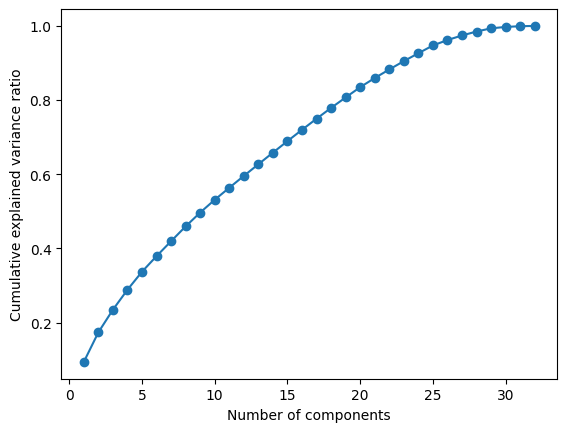

In [7]:
# Instantiate a PCA object with all components
pca = PCA()

# Fit the PCA model to the data
pca.fit(X_scaled)

# Get the explained variance ratios
variance_ratios = pca.explained_variance_ratio_

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(variance_ratios)

# Plot the cumulative explained variance ratio
plt.plot(np.arange(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'o-')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance ratio')
plt.show()

In [8]:
# Instantiate a PCA object with 20 components which explain around 80% of the variance
pca = PCA(n_components=10)

# Fit the PCA model to the standardized data
pca.fit(X_scaled)

# Transform the data using the PCA model
X_pca = pca.transform(X_scaled)

# Print the transformed data
print(X_pca)

[[ 4.91669174  2.44891477 -1.92929806 ...  0.63488319  0.23378162
   1.37426093]
 [ 2.36564139  1.97272349 -1.83109612 ... -0.07422298  3.02181759
   0.64311967]
 [ 0.03826349  2.98500199 -1.81082874 ...  0.411246   -0.7344069
  -0.7603812 ]
 ...
 [ 1.7565229  -1.54283193  2.30640913 ... -0.28629781  0.31229343
  -0.71716821]
 [ 1.25180446 -2.87247435  1.92611741 ...  0.70509782  0.37605093
  -0.06784244]
 [ 1.86742175 -1.49234709  2.01429738 ... -0.43459995 -0.07844695
   0.90355107]]


# Random Forest Classifier
Let's see what effect over- and undersampling have on the predictions of our Random Forest classifier. Here we don't use the reduced training data from the PCA because Random Forest is able to run in a decent time with the original data.

Random Forest Classifier (no imbalance technique used)
                   pre       rec       spe        f1       geo       iba       sup

   no fraud       0.94      1.00      0.02      0.97      0.13      0.02      4349
      fraud       0.83      0.02      1.00      0.04      0.13      0.02       277

avg / total       0.93      0.94      0.08      0.91      0.13      0.02      4626



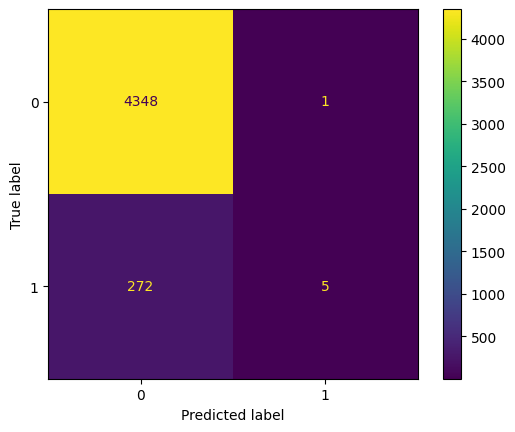


 RF with SMOTE
                   pre       rec       spe        f1       geo       iba       sup

   no fraud       0.94      1.00      0.03      0.97      0.16      0.03      4349
      fraud       0.50      0.03      1.00      0.05      0.16      0.02       277

avg / total       0.92      0.94      0.08      0.91      0.16      0.03      4626



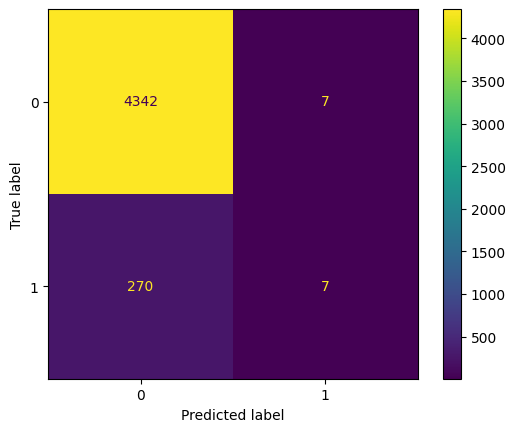


 RF with near miss 1
                   pre       rec       spe        f1       geo       iba       sup

   no fraud       0.99      0.60      0.90      0.75      0.74      0.53      4349
      fraud       0.13      0.90      0.60      0.22      0.74      0.56       277

avg / total       0.94      0.62      0.88      0.72      0.74      0.53      4626



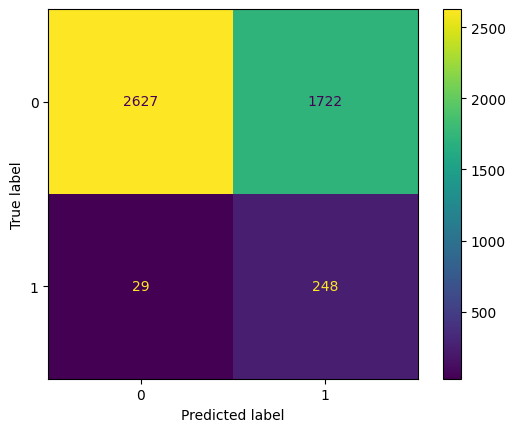


 RF EasyEnsemble
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.60      0.94      0.75      0.75      0.55      4349
          1       0.13      0.94      0.60      0.23      0.75      0.59       277

avg / total       0.94      0.62      0.92      0.72      0.75      0.55      4626



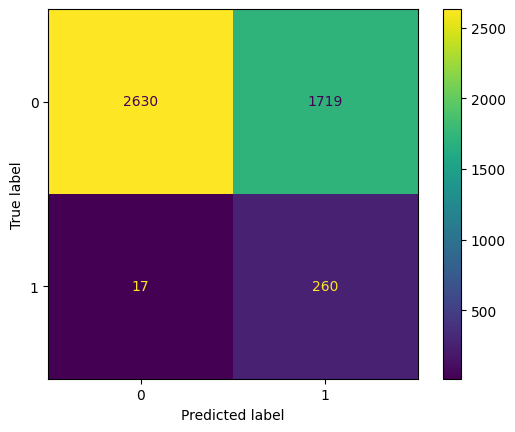

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

pipeline = make_pipeline(RandomForestClassifier(n_estimators=150, random_state=42))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Random Forest Classifier (no imbalance technique used)")
print(classification_report_imbalanced(y_test, y_pred, target_names=['no fraud', 'fraud']))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


#OVERSAMPLING using SMOTE (Synthetic Minority Over-sampling Technique)
pipeline = make_pipeline(SMOTE(random_state=3, k_neighbors=5),
                         RandomForestClassifier(n_estimators=150, random_state=42))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("\n RF with SMOTE")
print(classification_report_imbalanced(y_test, y_pred, target_names=['no fraud', 'fraud']))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


#UNDERSAMPLING using NearMiss
pipeline = make_pipeline(NearMiss(version=1),
                         RandomForestClassifier(n_estimators=150, random_state=42))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("\n RF with near miss 1")
print(classification_report_imbalanced(y_test, y_pred, target_names=['no fraud', 'fraud']))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


#Easy Ensemble with RF instead of AdaBoostClassifier()
ee = EasyEnsembleClassifier(estimator=RandomForestClassifier(n_estimators=150, random_state=42), random_state=42)
ee.fit(X_train, y_train)
y_pred = ee.predict(X_test)

print("\n RF EasyEnsemble")
print(classification_report_imbalanced(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Gaussian Naive Bayes

GaussianNB (no imbalance technique used)
                   pre       rec       spe        f1       geo       iba       sup

   no fraud       0.94      0.95      0.13      0.94      0.35      0.13      4349
      fraud       0.13      0.13      0.95      0.13      0.35      0.11       277

avg / total       0.90      0.90      0.18      0.90      0.35      0.13      4626



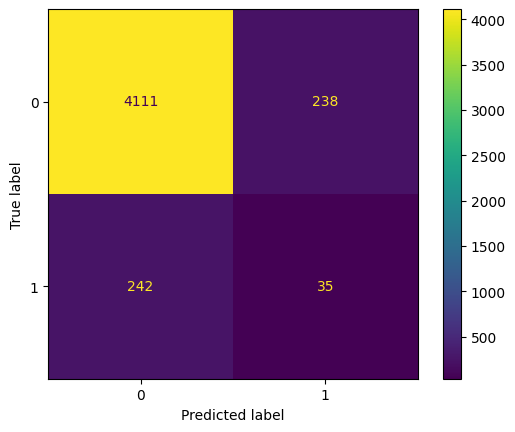


 NB with SMOTE
                   pre       rec       spe        f1       geo       iba       sup

   no fraud       0.98      0.65      0.78      0.78      0.71      0.50      4349
      fraud       0.12      0.78      0.65      0.21      0.71      0.51       277

avg / total       0.93      0.66      0.77      0.75      0.71      0.50      4626



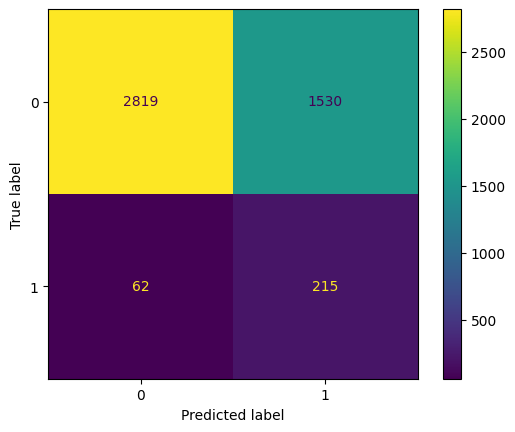


 NB with near miss 1
                   pre       rec       spe        f1       geo       iba       sup

   no fraud       0.95      0.86      0.22      0.90      0.44      0.20      4349
      fraud       0.09      0.22      0.86      0.13      0.44      0.18       277

avg / total       0.89      0.82      0.26      0.85      0.44      0.20      4626



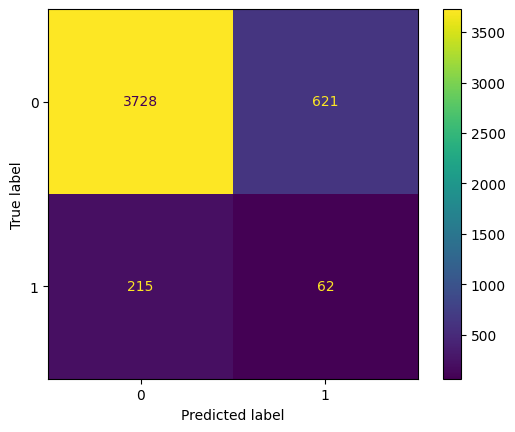


 NB EasyEnsemble
                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.66      0.72      0.79      0.69      0.48      4349
          1       0.12      0.72      0.66      0.21      0.69      0.48       277

avg / total       0.92      0.67      0.72      0.75      0.69      0.48      4626



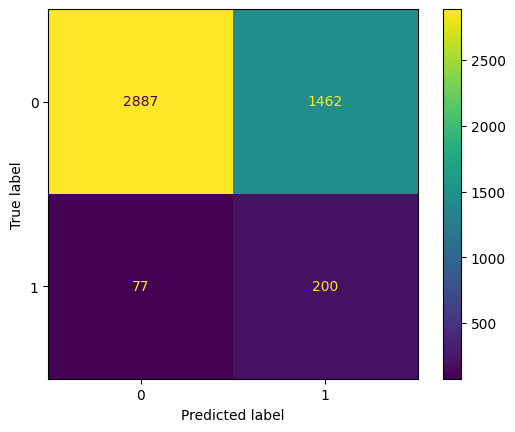

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

pipeline = make_pipeline(GaussianNB())
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("GaussianNB (no imbalance technique used)")
print(classification_report_imbalanced(y_test, y_pred, target_names=['no fraud', 'fraud']))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


#OVERSAMPLING using SMOTE (Synthetic Minority Over-sampling Technique)
pipeline = make_pipeline(SMOTE(random_state=3, k_neighbors=5),
                         GaussianNB())
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("\n NB with SMOTE")
print(classification_report_imbalanced(y_test, y_pred, target_names=['no fraud', 'fraud']))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


#UNDERSAMPLING using NearMiss
pipeline = make_pipeline(NearMiss(version=1),
                         GaussianNB())
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("\n NB with near miss 1")
print(classification_report_imbalanced(y_test, y_pred, target_names=['no fraud', 'fraud']))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


#Easy Ensemble with NB instead of AdaBoostClassifier()
ee = EasyEnsembleClassifier(estimator=GaussianNB(), random_state=42)
ee.fit(X_train, y_train)
y_pred = ee.predict(X_test)

print("\n NB EasyEnsemble")
print(classification_report_imbalanced(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Linear SVM

SVM (no imbalance technique used)
                   pre       rec       spe        f1       geo       iba       sup

   no fraud       0.94      1.00      0.00      0.97      0.00      0.00      4349
      fraud       0.00      0.00      1.00      0.00      0.00      0.00       277

avg / total       0.88      0.94      0.06      0.91      0.00      0.00      4626



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


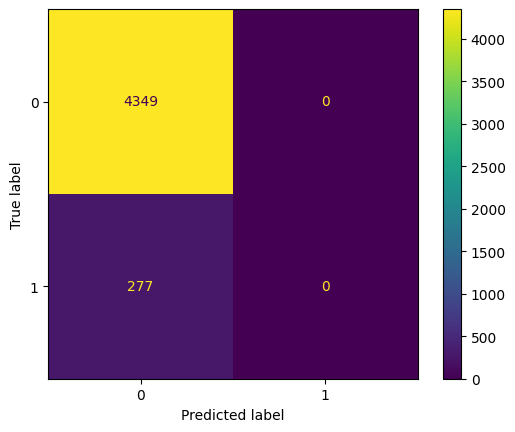


 SVM with SMOTE
                   pre       rec       spe        f1       geo       iba       sup

   no fraud       0.97      0.49      0.77      0.65      0.62      0.37      4349
      fraud       0.09      0.77      0.49      0.16      0.62      0.39       277

avg / total       0.92      0.51      0.76      0.62      0.62      0.37      4626



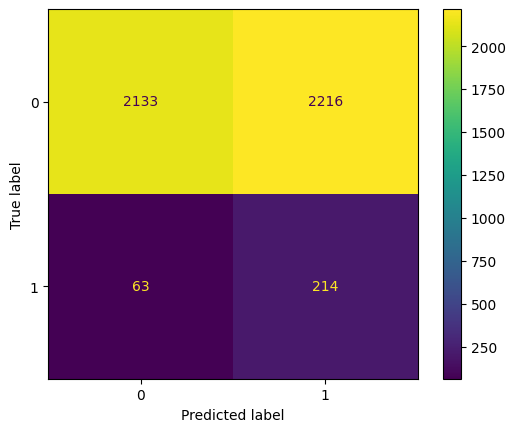


 SVM with near miss 1
                   pre       rec       spe        f1       geo       iba       sup

   no fraud       0.94      0.62      0.36      0.74      0.47      0.23      4349
      fraud       0.06      0.36      0.62      0.10      0.47      0.21       277

avg / total       0.88      0.60      0.37      0.70      0.47      0.23      4626



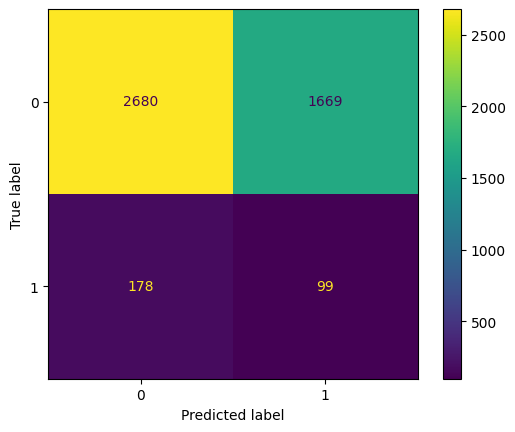


 SVM EasyEnsemble
                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.49      0.75      0.65      0.61      0.36      4349
          1       0.09      0.75      0.49      0.15      0.61      0.38       277

avg / total       0.92      0.51      0.74      0.62      0.61      0.36      4626



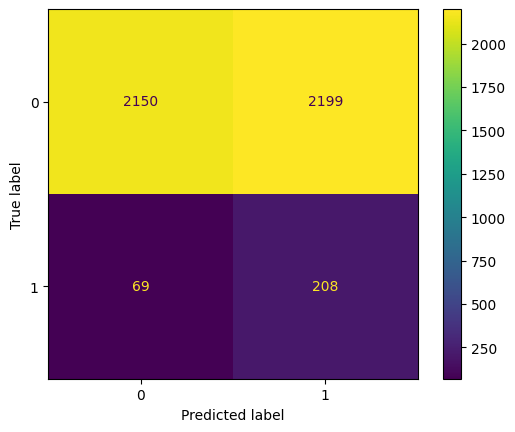

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

pipeline = make_pipeline(SVC(kernel='linear'))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("SVM (no imbalance technique used)")
print(classification_report_imbalanced(y_test, y_pred, target_names=['no fraud', 'fraud']))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


#OVERSAMPLING using SMOTE (Synthetic Minority Over-sampling Technique)
pipeline = make_pipeline(SMOTE(random_state=3, k_neighbors=5),
                         SVC(kernel='linear'))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("\n SVM with SMOTE")
print(classification_report_imbalanced(y_test, y_pred, target_names=['no fraud', 'fraud']))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


#UNDERSAMPLING using NearMiss
pipeline = make_pipeline(NearMiss(version=1),
                         SVC(kernel='linear'))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("\n SVM with near miss 1")
print(classification_report_imbalanced(y_test, y_pred, target_names=['no fraud', 'fraud']))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


#Easy Ensemble with NB instead of AdaBoostClassifier()
ee = EasyEnsembleClassifier(estimator=SVC(kernel='linear'), random_state=42)
ee.fit(X_train, y_train)
y_pred = ee.predict(X_test)

print("\n SVM EasyEnsemble")
print(classification_report_imbalanced(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

EasyEnsemble with AdaBoostClassifier
                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.57      0.75      0.72      0.65      0.42      4349
          1       0.10      0.75      0.57      0.18      0.65      0.44       277

avg / total       0.92      0.58      0.74      0.69      0.65      0.42      4626



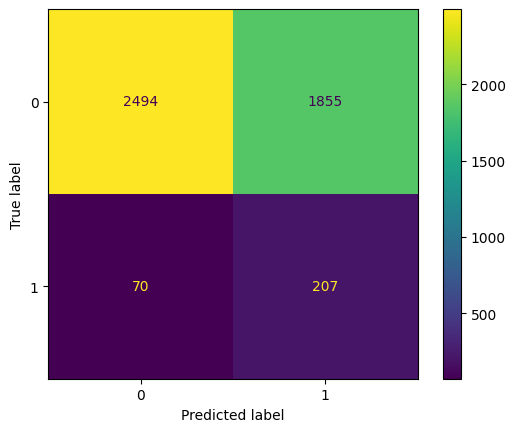

In [12]:
#Easy Ensemble with AdaBoostClassifier()
ee = EasyEnsembleClassifier(random_state=42)
ee.fit(X_train, y_train)
y_pred = ee.predict(X_test)

print("EasyEnsemble with AdaBoostClassifier")
print(classification_report_imbalanced(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()